# Using the Replica Trick to Compute Marginal Entropies

In [1]:
import sys
from pathlib import Path
sys.path = list(set(sys.path + ["../python"]))

In [2]:
import numpy
import pandas as pd
from gaussian_system import System, time_matrix, replica_estimate_sim, estimate_entropy_replica

In [3]:
path = Path.cwd().parent / "plots"
assert path.exists()
path

PosixPath('/Users/mr/Git/Gillespie/plots')

First define the system (i.e. the correlation functions)

In [4]:
system = System(lamda = 0.005, kappa = 0.25, rho = 0.01, mu = 0.01)

Set the trajectory length

In [5]:
traj_len = 500

In [6]:
def generate_replica_data():
    data = []
    for dim in [5, 50, 200]:
        data.append(replica_estimate_sim(system, dim, 64, 100, 100, 10))
        
    pd.concat(data, ignore_index=True).to_json(
        path / "replica" / "replica_data_1.json", orient="table"
    )

In [7]:
# generate_replica_data()

Run a linear model fit to find the slope of the replica lines

In [8]:
replica_data = pd.read_json(path / "replica" / "replica_data_1.json", orient="table")
result = estimate_entropy_replica(replica_data)
result.to_json(path / "replica" / "estimates_1.json", orient="table")
result

n  log_marginal_power  num_responses  num_signals
dim delta_t                                                    
5   64        1          -16.180737            100        10000
    64        2          -31.891648            100        20000
    64        3          -46.305118            100        30000
    64        4          -61.544257            100        40000
    64        5          -76.969294            100        50000
    64        6          -90.699350            100        60000
    64        7         -106.305765            100        70000
    64        8         -121.201220            100        80000
    64        9         -136.527606            100        90000
    64       10         -150.453855            100       100000
50  64        1         -158.422906            100        10000
    64        2         -315.962333            100        20000
    64        3         -481.943902            100        30000
    64        4         -645.511439            100    

PatsyError: Error evaluating factor: NameError: name 'log_marginal_power' is not defined
    log_marginal_power ~ 0 + n
    ^^^^^^^^^^^^^^^^^^

Now we plot the replica results

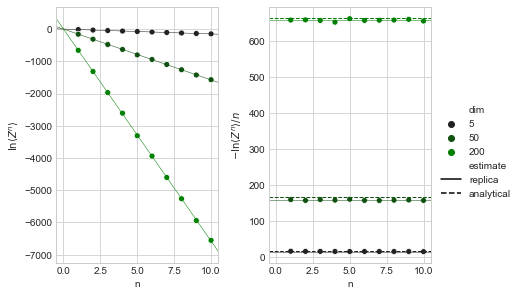

In [26]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')

replica_data = pd.read_json(path / "replica" / "replica_data_1.json", orient="table")

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, constrained_layout=True, subplot_kw={"xlim": (-0.5, 10.5)})
palette = sns.dark_palette("green", replica_data.dim.unique().size)
sns.scatterplot(x="n", y="logZ^n", hue="dim", palette=palette, data=replica_data, ax=ax1, legend=None)
sns.scatterplot(x="n", y="-logZ^n/n", hue="dim", palette=palette, data=replica_data.assign(**{'-logZ^n/n': lambda x: -x['logZ^n']/x.n}), ax=ax2, legend=None)

replica_estimate = pd.read_json(path / "replica" / "estimates_1.json", orient="table")
replica_estimate["analytical"] = replica_estimate.astype(object).apply(lambda s: system.marginal_entropy(time_matrix(s["dim"], s["delta_t"])), axis="columns")

for (i, est) in replica_estimate.iterrows():
    n = numpy.array(ax1.get_xlim())
    ax1.plot(n, -est['marginal_entropy']*n, color=palette[i], linewidth=0.5)
    ax2.plot(n, est['marginal_entropy']*numpy.ones_like(n), color=palette[i], linewidth=0.5)
    ax2.plot(n, est['analytical']*numpy.ones_like(n), linestyle='--', color=palette[i], linewidth=1)

ax1.set(ylabel=r"$\ln \langle Z^n \rangle$")
ax2.set(ylabel=r"$-\ln \langle Z^n \rangle / n$")

patch = matplotlib.pyplot.scatter
legend_handles = [patch([], [], visible=False, label="dim")]
for (i, est) in replica_estimate.iterrows():
    legend_handles.append(patch([], [], color=palette[i], label=int(est.dim)))
patch = matplotlib.lines.Line2D
legend_handles.append(patch([], [], visible=False, label="estimate", color='black'))
legend_handles.append(patch([], [], label="replica", color='black'))
legend_handles.append(patch([], [], linestyle='--', label="analytical", color='black'))

from matplotlib.legend_handler import HandlerCircleCollection

legend = fig.legend(handles=legend_handles, bbox_to_anchor=(1, 0.5), loc='center left')
fig.savefig(path / "replica" / "plot.pdf", bbox_inches='tight')

In [27]:
result["analytical"] = result.astype(object).apply(lambda s: system.marginal_entropy(time_matrix(s["dim"], s["delta_t"])), axis="columns")

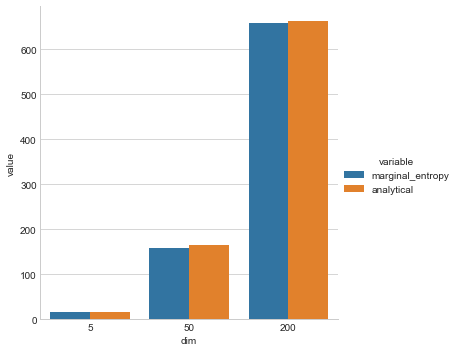

In [28]:
plot_data = result.melt(["dim", "delta_t", "num_signals", "num_responses"])
sns.catplot(x="dim", y="value", hue="variable", kind="bar", data=plot_data[plot_data.variable != "stderr"])